### Desigualdades no Brasil

##### O Aquecimento Global é sentido igualmente por habitantes de uma mesma metrópole?
Analisando indicadores do aquecimento global, como nível de temperatura e desastres naturais, seus remediadores e também avaliando a distribuição entre bairros do Rio de Janeiro. 


#### Descrição

To-do

- plotar ips (10 maiores e 10 menores)
- extrair horário da string de data

plotar indicadores qualidade do ar:
- fazer plot de O3 em função do tempo 
- fazer plot de PM10 em função do tempo

.

- fazer plot da umidade em função do tempo

- Fazer plot da temperatura em função do tempo
    
- Fazer plot das chuvas em função do tempo
    

In [14]:
import pandas                as pd
import matplotlib.pyplot     as plt
import re

In [2]:
# índice de progresso
df_ip = pd.read_csv('./data/dimensoes_componentes.csv', index_col = 0).reset_index()
# estação metereológica (qualidade do ar)
df_q = pd.read_csv('./data/qualidade_do_ar.csv', index_col = 0).reset_index()

In [3]:
regions = df_ip['regiao_administrativa'].unique()

#centro = df_ip[df_ip['regiao_administrativa'].str.contains('Centro')]

recent = df_ip[df_ip['ano'] == 2020]


l_df = recent.nlargest(10, ['ips_geral'])['regiao_administrativa'] # df
largest = [l_df[key] for key in l_df.keys()] # array with district names

s_df = recent.nsmallest(10, ['ips_geral'])['regiao_administrativa'] # df
smallest = [s_df[key] for key in s_df.keys()] # array with district names

largest, smallest

# fazer plot aqui

(['Botafogo',
  'Copacabana',
  'Lagoa',
  'Vila Isabel',
  'Tijuca',
  'Barra Da Tijuca',
  'Méier',
  'Iraja',
  'Santa Teresa',
  'Ilha Do Governador'],
 ['Portuaria',
  'Pavuna',
  'Guaratiba',
  'Complexo Do Alemão',
  'Jacarezinho',
  'Maré',
  'Cidade De Deus',
  'Santa Cruz',
  'Bangu',
  'São Cristovão'])

In [145]:
s_names = [
    'Bangu',         'Campo Grande', 'Centro', 
    'Copacabana',    'Irajá', 'Pedra de Guaratiba', 
    'São Cristóvão', 'Tijuca'
    ]

# monitored params from API website description
stations = [ 
    { "code": "CA",     "name": "Centro",             "air_params": ["O3", "CO", "PM10"] },
    { "code": "AV",     "name": "Copacabana",         "air_params": ["O3", "CO", "PM10", "SO2"] },
    { "code": "SC",     "name": "São Cristóvão",      "air_params": ["O3", "CO", "PM10", "SO2"] },
    { "code": "SP",     "name": "Tijuca",             "air_params": ["O3", "CO", "PM10", "SO2", "NOx"] },
    { "code": "IR" ,    "name": "Irajá",              "air_params": ["O3", "CO", "PM10", "SO2", "NOx", "HC", "PM2.5"] },
    { "code": "BG" ,    "name": "Bangu",              "air_params": ["O3", "CO", "PM10", "SO2", "NOx", "HC"] },
    { "code": "CG" ,    "name": "Campo Grande",       "air_params": ["O3", "CO", "PM10", "SO2", "NOx", "HC"] },
    { "code": "PG" ,    "name": "Pedra de Guaratiba", "air_params": ["O3", "PM10"] }
]

centro       = df_q[df_q['Estação'].str.contains('CA') ]
copa         = df_q[df_q['Estação'].str.contains('AV') ] ###
sao_crist    = df_q[df_q['Estação'].str.contains('SC') ] ##
tijuca       = df_q[df_q['Estação'].str.contains('SP') ] ##
iraja        = df_q[df_q['Estação'].str.contains('IR') ] ### 
bangu        = df_q[df_q['Estação'].str.contains('BG') ] ##
campo_grande = df_q[df_q['Estação'].str.contains('CG') ]
pedra_guarat = df_q[df_q['Estação'].str.contains('PG') ] 

,1Data,CodNum,Estação,Chuva,Pres,RS,Temp,UR,Dir_Vento,Vel_Vento,...,NO,NOx,O3,PM10,PM2_5,Lat,Lon,X_UTM_Sirgas2000,Y_UTM_Sirgas2000,OBJECTID
387058,2011/01/01 00:30:00+00,8,SP,0.0,1007.45,6.40,20.91,89.49,176.83,2.92,...,NaN,NaN,5.08,44.05,NaN,-22.924915,-43.232657,681240.2399,7463702.987,387059
387059,2011/01/01 01:30:00+00,8,SP,0.0,1006.57,6.50,20.53,92.83,211.17,2.82,...,NaN,NaN,11.90,55.89,NaN,-22.924915,-43.232657,681240.2399,7463702.987,387060
387060,2011/01/01 02:30:00+00,8,SP,0.4,1006.43,6.42,19.29,99.02,236.33,2.88,...,NaN,NaN,3.89,35.37,NaN,-22.924915,-43.232657,681240.2399,7463702.987,387061
387061,2011/01/01 03:30:00+00,8,SP,0.0,1006.35,6.35,18.80,100.00,178.33,2.87,...,NaN,NaN,20.20,30.73,NaN,-22.924915,-43.232657,681240.2399,7463702.987,387062
387062,2011/01/01 04:30:00+00,8,SP,0.2,1006.50,6.43,18.67,100.00,230.33,2.45,...,NaN,NaN,16.59,12.00,NaN,-22.924915,-43.232657,681240.2399,7463702.987,387063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661657,2021/03/31 19:30:00+00,8,SP,0.0,1007.52,0.00,23.32,56.17,235.83,0.37,...,6.89,21.42,29.79,22.10,NaN,-22.924915,-43.232657,681240.2399,7463702.987,661660
661658,2021/03/31 20:30:00+00,8,SP,0.0,1008.32,0.00,23.28,54.83,235.00,0.57,...,5.66,18.57,31.02,22.14,NaN,-22.924915,-43.232657,681240.2399,7463702.987,661661
661659,2021/03/31 21:30:00+00,8,SP,0.0,1008.73,0.00,23.02,56.45,204.50,0.33,...,4.02,13.97,31.24,21.07,NaN,-22.924915,-43.232657,681240.2399,7463702.987,661662
661660,2021/03/31 22:30:00+00,8,SP,1.2,1008.85,0.00,20.80,74.52,292.00,0.60,...,2.46,9.19,29.33,28.97,NaN,-22.924915,-43.232657,681240.2399,7463702.987,661663


In [146]:
tijuca

,1Data,CodNum,Estação,Chuva,Pres,RS,Temp,UR,Dir_Vento,Vel_Vento,...,NO,NOx,O3,PM10,PM2_5,Lat,Lon,X_UTM_Sirgas2000,Y_UTM_Sirgas2000,OBJECTID
387058,2011/01/01 00:30:00+00,8,SP,0.0,1007.45,6.40,20.91,89.49,176.83,2.92,...,NaN,NaN,5.08,44.05,NaN,-22.924915,-43.232657,681240.2399,7463702.987,387059
387059,2011/01/01 01:30:00+00,8,SP,0.0,1006.57,6.50,20.53,92.83,211.17,2.82,...,NaN,NaN,11.90,55.89,NaN,-22.924915,-43.232657,681240.2399,7463702.987,387060
387060,2011/01/01 02:30:00+00,8,SP,0.4,1006.43,6.42,19.29,99.02,236.33,2.88,...,NaN,NaN,3.89,35.37,NaN,-22.924915,-43.232657,681240.2399,7463702.987,387061
387061,2011/01/01 03:30:00+00,8,SP,0.0,1006.35,6.35,18.80,100.00,178.33,2.87,...,NaN,NaN,20.20,30.73,NaN,-22.924915,-43.232657,681240.2399,7463702.987,387062
387062,2011/01/01 04:30:00+00,8,SP,0.2,1006.50,6.43,18.67,100.00,230.33,2.45,...,NaN,NaN,16.59,12.00,NaN,-22.924915,-43.232657,681240.2399,7463702.987,387063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661657,2021/03/31 19:30:00+00,8,SP,0.0,1007.52,0.00,23.32,56.17,235.83,0.37,...,6.89,21.42,29.79,22.10,NaN,-22.924915,-43.232657,681240.2399,7463702.987,661660
661658,2021/03/31 20:30:00+00,8,SP,0.0,1008.32,0.00,23.28,54.83,235.00,0.57,...,5.66,18.57,31.02,22.14,NaN,-22.924915,-43.232657,681240.2399,7463702.987,661661
661659,2021/03/31 21:30:00+00,8,SP,0.0,1008.73,0.00,23.02,56.45,204.50,0.33,...,4.02,13.97,31.24,21.07,NaN,-22.924915,-43.232657,681240.2399,7463702.987,661662
661660,2021/03/31 22:30:00+00,8,SP,1.2,1008.85,0.00,20.80,74.52,292.00,0.60,...,2.46,9.19,29.33,28.97,NaN,-22.924915,-43.232657,681240.2399,7463702.987,661663


In [181]:
def getTime(date_time):
    r = '[0-9]{2}:[0-9]{2}'
    time = re.match(r, date_time)

    return time
    
def getDate(date_time):
    r = '[0-9]{4}[\/][0-9]{2}[\/][0-9]{2}'
    date = re.match(r,date_time)

    return date

# adjust so they end on the same time
def adjustDateTime(df, date_time=None):
    
    # beggining index
    idx_start = df.index.values[0]
    
    # last value as default
    idx_end = df.index.values[-1]


    try: # get index for same data value
        idx_end = df['1Data'].where(df['1Data'].values == date_time).dropna().index[0]
    except: # exception for tijuca's missing value
        idx_end = df['1Data'].where(df['1Data'].values == '2020/10/29 08:30:00+00').dropna().index[0]
    
    # stop after last date_time 
    return df.truncate(before=idx_start, after=idx_end)
    
    

In [193]:
# date to adjust the others
date_time = copa.tail(1)['1Data'].iloc[0]

sc = adjustDateTime(sao_crist, date_time)                         # stoped at 2021/03/31
sao_crist_24h = sc[['1Data', 'Temp', 'O3', 'PM10']].tail(24) 

# reference: last measurement
copa_24h      = copa[['1Data', 'Temp', 'O3', 'PM10']].tail(24)     # stops at 2020/10/29

t = adjustDateTime(tijuca, date_time)                             # stoped at 2021/03/31
tijuca_24h    = t[['1Data', 'Temp', 'O3', 'PM10']].tail(24)    

i = adjustDateTime(iraja, date_time)                              # stoped at 2021/03/31
iraja_24h     = i[['1Data', 'Temp', 'O3', 'PM10']].tail(24)     

b = adjustDateTime(bangu, date_time)                           # stoped at 2021/03/01
bangu_24h     = b[['1Data', 'Temp', 'O3', 'PM10']].tail(24)     # stoped at 2021/03/01

tijuca_24h

,1Data,Temp,O3,PM10
657989,2020/10/28 09:30:00+00,36.57,36.30,44.85
657990,2020/10/28 10:30:00+00,39.03,55.85,61.46
657991,2020/10/28 11:30:00+00,40.30,108.19,79.15
657992,2020/10/28 12:30:00+00,38.73,114.06,64.40
657993,2020/10/28 13:30:00+00,38.42,106.47,43.68
657994,2020/10/28 14:30:00+00,35.37,104.70,31.98
657995,2020/10/28 15:30:00+00,33.68,101.45,25.56
657996,2020/10/28 16:30:00+00,31.43,111.27,20.46
657997,2020/10/28 17:30:00+00,29.97,110.15,26.30
657998,2020/10/28 18:30:00+00,28.92,93.14,27.38


<AxesSubplot:xlabel='PM10', ylabel='1Data'>

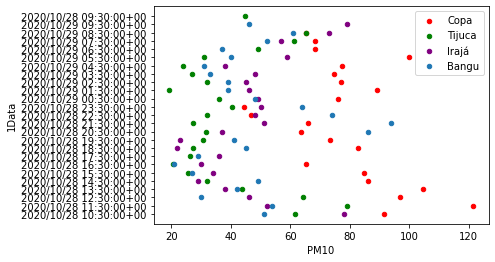

In [189]:
ax = copa_24h.plot(kind='scatter', x='PM10', y='1Data', label='Copa', color='Red')
tijuca_24h.plot(kind='scatter', x='PM10', y='1Data', label='Tijuca', ax=ax, color='Green')
iraja_24h.plot(kind='scatter', x='PM10', y='1Data', label='Irajá', ax=ax, color='Purple')
bangu_24h.plot(kind='scatter', x='PM10', y='1Data', label='Bangu', ax=ax)